In [128]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

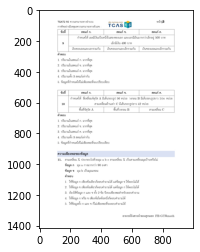

In [129]:
img = cv2.imread('./test_image/test8.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img)

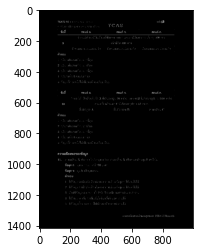

In [130]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img)

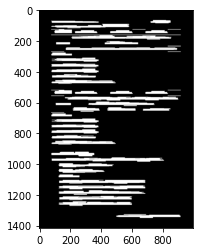

In [131]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [132]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

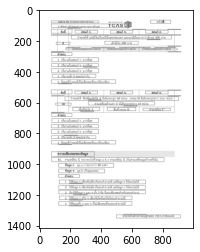

In [133]:
img2 = img.copy()
cropped_images = []

for ctr in sorted_contours_lines:
    x, y, w, h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (40, 100, 250), 2)
    cropped_region = img2[y:y+h, x:x+w] 
    cropped_images.append(cropped_region)

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), cmap='gray') 
plt.show()
cv2.imshow(f'Cropped Image {1}', cv2.cvtColor(cropped_images[13], cv2.COLOR_BGR2GRAY))

cv2.waitKey(0)
cv2.destroyAllWindows()

In [134]:

gray_img = cv2.cvtColor(cropped_images[13], cv2.COLOR_BGR2GRAY)
ones_array = np.where(gray_img == 255, 1, 0)

ones_img = np.uint8(ones_array * 255)


cv2.waitKey(0)
cv2.destroyAllWindows()

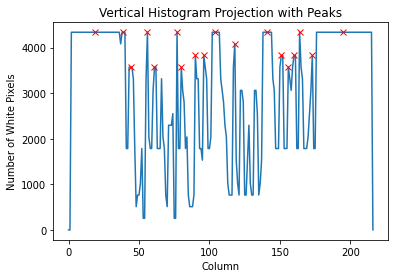

In [135]:
from scipy.signal import find_peaks

vertical_hist = np.sum(ones_img, axis=0, keepdims=True)
peaks, _ = find_peaks(vertical_hist[0], height=3500)


# แสดงกราฟ
plt.plot(vertical_hist[0])
plt.plot(peaks, vertical_hist[0][peaks], 'x', color='red')
plt.title('Vertical Histogram Projection with Peaks')
plt.xlabel('Column')
plt.ylabel('Number of White Pixels')
plt.show()



In [136]:
print(peaks)

[ 19  39  44  56  61  77  80  90  96 104 118 141 151 156 160 164 173 195]


In [137]:
def character_segmentation(word_segment, character_threshold=3500, character_width=10, character_gap=5):
    vertical_projection = np.sum(word_segment, axis=0)
    character_peaks, _ = find_peaks(vertical_projection, height=character_threshold)

    segmented_characters = []

    for peak_column in character_peaks:
        middle_column = peak_column
        start_column = max(0, middle_column - character_width // 2 - character_gap)
        end_column = min(word_segment.shape[1], middle_column + character_width // 2)
        character_segment = word_segment[:, start_column:end_column]
        segmented_characters.append(character_segment)

    return segmented_characters




In [142]:
segmented_characters = character_segmentation(ones_img, character_threshold=50)

characters_list = []

for i, char_segment in enumerate(segmented_characters):
    characters_list.append(char_segment)

for i, char_segment in enumerate(characters_list):
    print(f'Character {i + 1}:')
    print(char_segment)
    print('\n')

cv2.imshow('Character 1', characters_list[3])

cv2.waitKey(0)

cv2.destroyAllWindows()


Character 1:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 